In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from sklearn.metrics import mean_squared_error, r2_score

import cvxpy as cvx

import pandas_datareader.data as web
import datetime

# Library with returns forecasting models
from PredictionModels import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import EfficientFrontier, objective_functions

Setting the data parameters

In [26]:
tickers = [
    'BTC-USD', # Bitcoin
    'SOL-USD', # Solana
    'ETH-USD', # Etherium
    'MSFT.MX', # Microsoft Corporation
    'GOOG', # Alphabet Inc. (Google)
    'WMT.MX', # Walmart Inc.
    'XOM', # Exxon Mobil Corporation
    'AZN.L', # AstraZeneca PLC
    'DIS.MX', # The Walt Disney Company
    'PG.MX', # The Procter & Gamble Company
    'KIM', # Kimco Realty Corporation
]

# Market capitalization in $Bln
caps = {
    'BTC-USD': 1751,
    'SOL-USD': 71.991,
    'ETH-USD': 191.258,
    'MSFT.MX': 52592,
    'GOOG': 1855,
    'WMT.MX': 14980,
    'XOM': 462.46,
    'AZN.L': 156.814,
    'DIS.MX': 3057,
    'PG.MX': 7980,
    'KIM': 13.991
}

start_date = '2018-01-01'
end_date = '2025-04-20'
period = '1d'

Determining the Markowitz model

In [27]:
class Markowitz(DataStore):
    def __init__(self, tickers=[], start_date = '2010-01-01', end_date = '2025-04-20', period = '1d', caps = caps):
        super().__init__(tickers, start_date, end_date, period, caps=caps)
        self.exp_returns = self.data[1].mean() * 252 # If we have daily data
        self.cov = self.data[1].cov() * 252
        self.length = self.exp_returns.shape[0]
    def optimize(self):
        """
        The function optimizes the weights using Markowitz approach
        The function returns optimized weights for Markowitz portfolio
        """
        Q = np.array(self.cov)
        q = np.array(self.exp_returns)
        # Inequalities are written as Gx <= h
        G = np.diag(-1*np.ones(self.length), 0)
        h = np.zeros(self.length, dtype=int)
        # Equality constraints are written as Ax == b
        A = np.ones(self.length, dtype=int)
        b = np.array([1])
        # Defining and solving the quandratic problem
        x = cvx.Variable(self.length)
        prob = cvx.Problem(cvx.Maximize((-1/2)*cvx.quad_form(x, Q) + q.T @ x),
            [G @ x <= h, A @ x == b])
        prob.solve()

        # Retrieving the weights
        x_values = x.value
        w = dict()
        for i in range(self.length):
            w[self.tickers[i]] = round(x_values[i], 4)

        return w

    def plot_weights(self):
        weights = self.optimize()
        fig = plt.figure(figsize=(15,5))
        plt.bar(weights.keys(), weights.values(), color='b', width=0.7)
        plt.title("Asset allocation by Markowitz model", y=1.05)
        plt.xlabel("Investment assets")
        plt.ylabel("Weights of assets in Markowitz portfolio")
        plt.grid()
        plt.show()


[*********************100%***********************]  11 of 11 completed


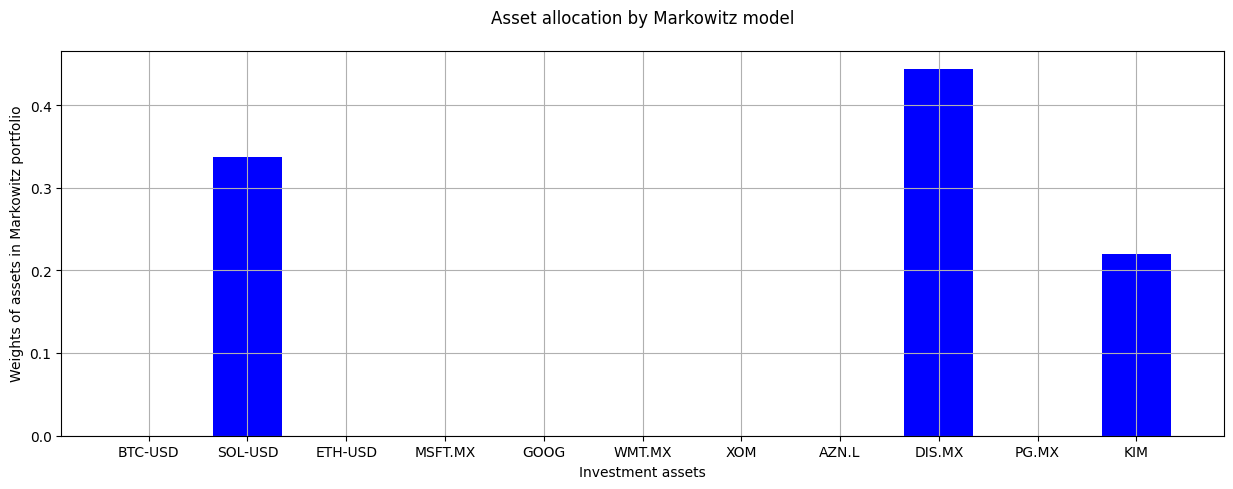

In [28]:
markowitz_model = Markowitz(tickers=tickers, start_date=start_date, end_date=end_date, period=period, caps=caps)
opt_weights = markowitz_model.optimize()
markowitz_model.plot_weights()

Black-Litterman model

In [44]:
class BlackLitterman(DataStore):
    def __init__(self, tickers=[], start_date = '2010-01-01', end_date = '2025-04-20', period = '1d', caps=caps):
        super().__init__(tickers, start_date, end_date, period, caps=caps)

        # Loading additional data of 3-month US treasure rates to calculate excess returns
        self.tickers = tickers
        self.start_date = start_date
        self.end_data = end_date
        self.t_rates = web.DataReader("TB3MS", 'fred', start=self.start_date, end=self.end_date)
        self.t_rates.reset_index(inplace=True)
        self.t_rates.rename(columns={"DATE": "Date"}, inplace=True)
        self.t_rates['TB3MS'] = self.t_rates['TB3MS'] / 100
        self.data[1].reset_index(inplace=True)
        print(self.data[1])

        # Merging the assets data and T-bill data
        self.full_data = pd.merge(self.data[1], self.t_rates, how='left', on='Date')
        # Filling in the gaps
        self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
        self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(0.0015)
        # Converting the rates into 1 day rate by dividing by 90 days
        self.full_data['TB3MS'] = self.full_data['TB3MS'] / 90

        # Dividing the data into treasury returns and other assets returns
        self.assets_returns = self.full_data[self.tickers]
        self.treasury_rate = self.full_data["TB3MS"]

    def equil_weights(self):
        """
            The function returns equilibrium weights calculated using market capitalization of assets (Yahoo Finance)
        """
        asset_weights = pd.DataFrame(self.caps.values(), index=self.caps.keys(), columns=['Cap'])
        asset_weights['Weights'] = asset_weights['Cap'].apply(lambda x: x / asset_weights['Cap'].sum())
        return asset_weights

    def implied_equil_returns(self):
        """

        """
        assets_weights = self.equil_weights()
        excess_returns = self.assets_returns.subtract(self.treasury_rate, axis=0)
        # Calculation of excess returns covariance matrix
        covar = excess_returns.cov() * 252
                # Risk-aversion parameter
        risk_aversion = 2.95
        print("risk_aversion=",risk_aversion)

        return self.implied_function(risk_aversion, covar, assets_weights['Weights'])


    def implied_function(self, risk_avers_param, sig, weights):
        """
            The function calculates equlibrium market returns

            Arg:
                - risk_avers_param (float) - risk-aversion parameter
                - sig (np.array) - covariance matrix of excess returns
                - weights (pd.Series) - equilibrium market weights
            return: equlibrium market returns
        """

        return risk_avers_param * sig.dot(weights).squeeze()


    def views_function(self):
        pass

    def function(self, predictions: dict, method: str):
        """
        The function returns the views matrix based on predictions
        """
        pass


    def function1(self):
        """
        The function does some!
        """

        pass


    def consolid_preds(self):
        """
        The function stores expected returns for each asset based on different models predictions
        """
        self.q_matrix = np.zeros(len(self.tickers))

        # Container of forecasts
        preds = np.zeros((3, len(self.tickers)))

        for i, ticker in enumerate(self.tickers):
            # Initializing the prediction models

            # DesicionTreeRegressor
            des_tree = DesicionTreeRegressorPredictor(
                ticker=ticker,
                start_date=self.start_date, # At this point I set start_date at default (dynamicaly it will differ or will be fixed)
                end_date=self.end_date,     # At this point I set end_date at default (dynamicaly it will differ)
                features_target=self.features_target
            )
            # LogisticRegression
            log_reg = LinearRegressionPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )

            svr_reg = SVRPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )

            # Making forecasts
            preds[0, i] = des_tree.make_forecast()[0]
            preds[1, i] = log_reg.make_forecast()[0]
            preds[2, i] = svr_reg.make_forecast()[0]

        return preds


In [30]:
# Checking the process
# bl = BlackLitterman(tickers, start_date, end_date, period)
# w = bl.implied_equil_returns()
# w

In [42]:
# tickers=[]
# start_date = '2010-01-01'
# end_date = '2025-04-20'
# period = '1d'
# t_rates = web.DataReader("TB3MS", 'fred', start=start_date, end=end_date)
# t_rates.reset_index(inplace=True)
# t_rates.rename(columns={"DATE": "Date"}, inplace=True)
# t_rates['TB3MS'] = t_rates['TB3MS'] / 100


# full_data = t_rates

# full_data['TB3MS'] = full_data['TB3MS'].fillna(method="ffill")
# full_data['TB3MS'] = full_data['TB3MS'].fillna(0.0015)
# full_data['TB3MS'] = full_data['TB3MS'] / 90

# assets_returns = full_data[tickers]
# treasury_rate = full_data["TB3MS"]


# asset_weights = pd.DataFrame(caps.values(), index=caps.keys(), columns=['Cap'])
# asset_weights['Weights'] = asset_weights['Cap'].apply(lambda x: x / asset_weights['Cap'].sum())
# assets_returns = full_data[tickers]
# excess_returns = assets_returns.subtract(treasury_rate, axis=0)

# covar = excess_returns.cov() * 252
#         # Risk-aversion parameter
# risk_aversion = 2.95

# prior = risk_aversion * covar.dot(asset_weights['Weights']).squeeze()

In [46]:
tickers = [
    'BTC-USD', # Bitcoin
    'SOL-USD', # Solana
    'ETH-USD', # Etherium
    'MSFT.MX', # Microsoft Corporation
    'GOOG', # Alphabet Inc. (Google)
    'WMT.MX', # Walmart Inc.
    'XOM', # Exxon Mobil Corporation
    'AZN.L', # AstraZeneca PLC
    'DIS.MX', # The Walt Disney Company
    'PG.MX', # The Procter & Gamble Company
    'KIM', # Kimco Realty Corporation
]

# Market capitalization in $Bln
caps = {
    'BTC-USD': 1751,
    'SOL-USD': 71.991,
    'ETH-USD': 191.258,
    'MSFT.MX': 52592,
    'GOOG': 1855,
    'WMT.MX': 14980,
    'XOM': 462.46,
    'AZN.L': 156.814,
    'DIS.MX': 3057,
    'PG.MX': 7980,
    'KIM': 13.991
}

start_date = '2018-01-01'
end_date = '2025-04-20'
period = '1d'

bl = BlackLitterman(tickers, start_date, end_date, period)

forecasts = bl.consolid_preds()
mean_preds = forecasts.mean(axis=0)
Q = pd.Series(mean_preds, index=tickers)

P = pd.DataFrame(
    np.eye(len(tickers)),
    index=tickers,
    columns=tickers
)


S           = bl.assets_returns.cov() * 252
prior       = bl.implied_equil_returns()   # π
confidences = [0.5, 0.5, 0.5, 0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]




# Creating model
bl2 = BlackLittermanModel(S, # Covariance Matrix
                         pi = prior, # Prior expected returns
                         Q = Q, # Vector of views
                         P = P, # Matrix mapping the views
                         omega = 'idzorek', # Confidence levels in %
                         view_confidences = confidences) # Confidences


rets = bl2.bl_returns() # Calculating Expected returns
ef = EfficientFrontier(rets, S) # Optimizing asset allocation

ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
weights1 = ef.clean_weights() # Cleaning weights
weights1 # Printing weights

[*********************100%***********************]  11 of 11 completed


Ticker       Date     AZN.L   BTC-USD    DIS.MX   ETH-USD      GOOG       KIM  \
0      2020-04-15  0.001183 -0.029713 -0.005028 -0.027726 -0.005340 -0.099887   
1      2020-04-16  0.026309  0.069029 -0.007945  0.116098  0.000792 -0.135446   
2      2020-04-17  0.019256 -0.002902  0.028783 -0.003018  0.015534  0.050585   
3      2020-04-20  0.018646 -0.030654 -0.026966  0.003830 -0.013052 -0.041196   
4      2020-04-21  0.003688 -0.000238 -0.005044  0.002554 -0.040498 -0.030845   
...           ...       ...       ...       ...       ...       ...       ...   
1196   2025-04-10  0.035665 -0.036352 -0.063141 -0.091283 -0.035968 -0.019535   
1197   2025-04-11 -0.000999  0.046364  0.003068  0.028892  0.025607  0.018046   
1198   2025-04-14  0.030699  0.013547 -0.017067  0.034876  0.012903  0.007917   
1199   2025-04-15 -0.003884 -0.010385  0.004095 -0.021261 -0.017430  0.000000   
1200   2025-04-16 -0.002532  0.004351 -0.034384 -0.006649 -0.020244 -0.006428   

Ticker   MSFT.MX     PG.MX 

<ipython-input-44-546fb9ea56d4>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")


risk_aversion= 2.95


OrderedDict([('BTC-USD', 0.0),
             ('SOL-USD', 0.0),
             ('ETH-USD', 0.0),
             ('MSFT.MX', 0.83077),
             ('GOOG', 0.0),
             ('WMT.MX', 0.0802),
             ('XOM', 0.06402),
             ('AZN.L', 0.0),
             ('DIS.MX', 0.0),
             ('PG.MX', 0.02501),
             ('KIM', 0.0)])

In [11]:
# Define the portfolios
portfolio1 = [    'BTC-USD',
    'SOL-USD',
    'ETH-USD',
    'MSFT.MX',
    'GOOG',
    'WMT.MX',
    'XOM',
    'AZN.L',
    'PG.MX',
    'KIM']

# Download historical data from Yahoo Finance
start_date = '2018-01-01'
end_date = '2025-04-20'
period = '1d'
portfolios = {'Portfolio 1': portfolio1}

# Fetch weekly adjusted close prices
weekly_data = {}
for name, tickers in portfolios.items():
    data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
    weekly_data[name] = data


prices_portfolio1 = weekly_data['Portfolio 1']

returns_portfolio1 = (prices_portfolio1.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)


[*********************100%***********************]  10 of 10 completed
<ipython-input-11-28e90091e6a2>:28: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio1 = (prices_portfolio1.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)


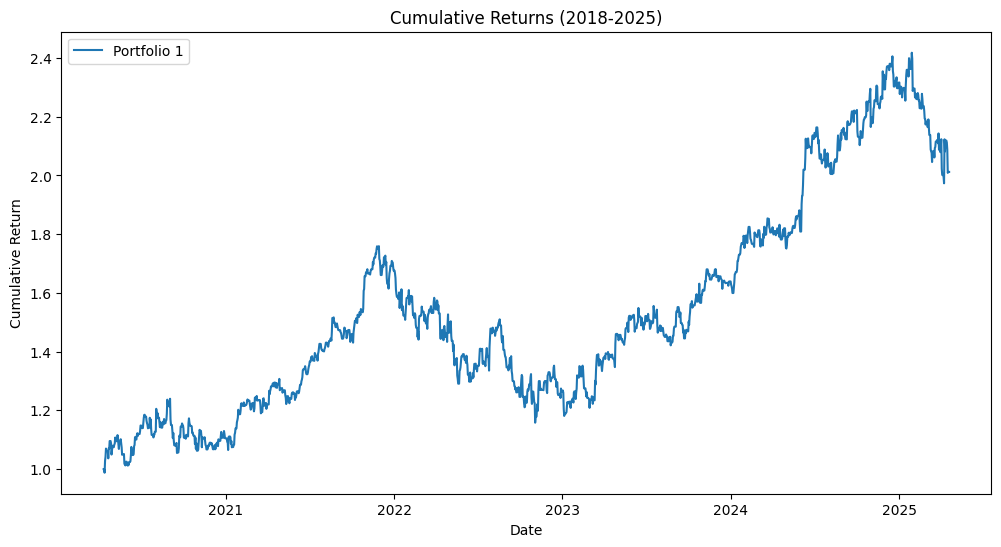

In [52]:
# Calculate cumulative returns for each portfolio
cumulative_returns_weighted = {}
cumulative_returns_weighted['Portfolio 1'] = (1 + returns_portfolio1).cumprod()


# Plot cumulative returns with manual weights
plt.figure(figsize=(12, 6))
for name, cumulative_return in cumulative_returns_weighted.items():
    plt.plot(cumulative_return, label=name)
plt.title('Cumulative Returns (2018-2025)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()